In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pdb
import json
import imageio
from pathlib import Path
from PIL import Image
from matplotlib import rc
from tqdm import tqdm

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

class ImageSet:
    def __init__(
        self, imgs_path, img_ext='png', 
        verbose=True, white_bg=True, 
        img_name_pattern=None, 
        zoom=None, img_size=None,
        patch=None, # draw a red box around the img. ((left, top), (wdith, height))
        patch_zoom=1.5, # zoom patch and place it somewhere
        patch_loc = 'bl', # bottom left, top left, bottom right top right
    ):
        self.imgs_path = Path(imgs_path)
        self.verbose = verbose
        self.img_ext = img_ext
        self.white_bg = white_bg
        self.img_name_pattern = img_name_pattern
        self.zoom = zoom
        self.img_size = img_size
        self.patch = patch
        self.patch_zoom = patch_zoom
        self.patch_loc = patch_loc
        
    def draw_box(self, img, left, right, top, bottom, line_width=10, line_color=(1,0,0)):
        patch = np.copy(img[top+line_width:bottom-line_width, left+line_width: right-line_width,:])
        img[top:bottom, left: right,:] = np.array(line_color)
        img[top+line_width:bottom-line_width, left+line_width: right-line_width,:] = patch
        return img
    
    
    def zoom_img(self, img, zoom):
        img = (img * 255).astype(np.uint8)
        img = Image.fromarray(img)
        original_size = img.size
        new_size = (int(original_size[0] * zoom), int(original_size[1] * zoom))
        img = img.resize(new_size, Image.LANCZOS)
        return np.array(img) / 255.
        
        
    def __len__(self):
        return len(list(self.imgs_path.glob(f'*.{self.img_ext}')))
        
    def __getitem__(self, key):
        if self.img_name_pattern is None:
            im_path = list(self.imgs_path.glob(f'*.{self.img_ext}'))
            im_path = sorted(im_path)

            if key >= len(im_path):
                raise Exception(f'Index {key} exceeds imgs in path {str(self.imgs_path)}')
            im_path = im_path[key]
        else:
            im_path = self.imgs_path / self.img_name_pattern.format(key)
        if self.verbose:
            print(f'Read: {str(im_path)}')

        im = imageio.imread(str(im_path)).astype('float') / 255

        if im.shape[-1] > 3:
            if self.white_bg:
                im = im[..., :3] * im[..., 3:] + (1.-im[..., 3:])
            else:
                im = im[..., :3] * im[..., 3:]
        
        if self.zoom is not None and self.zoom != 1.:
#             im = (im * 255).astype(np.uint8)
#             img = Image.fromarray(im)
#             original_size = img.size
#             new_size = (int(original_size[0] * self.zoom), int(original_size[1] * self.zoom))
#             img = img.resize(new_size, Image.LANCZOS)
#  im = np.array(img) / 255.
            im = self.zoom_img(im, self.zoom)

            # width, height = new_size
            # new_width, new_height =  original_size

            # left = (width - new_width)//2
            # top = (height - new_height)//2
            # right = (width + new_width)//2
            # bottom = (height + new_height)//2

            # img = img.crop((left, top, right, bottom))
#            
        
        if self.img_size is not None:
#             width, height = im.shape[:2]
#             new_width, new_height = self.img_size
#             left = (width - new_width)//2
#             top = (height - new_height)//2
#             right = (width + new_width)//2
#             bottom = (height + new_height)//2

            height, width = im.shape[:2]
            new_width, new_height = self.img_size
            left = (width - new_width)//2
            top = (height - new_height)//2
            right = (width + new_width)//2
            bottom = (height + new_height)//2
            
#             pdb.set_trace()

#             im = im[left:right, top:bottom, :]
            im = im[top:bottom, left:right, :]
    
        if self.patch is not None:
#             pdb.set_trace()
            # draw and zoom a patch
            ((left, top), (width, height)) = self.patch
#             print("[left, top, wdith, height]")
#             print([left, top, wdith, height])
            bottom = top + height
            right = left + width
            
#             print("[left, top, right, bottom]")
#             print([left, top, right, bottom])
            
            img_patch = np.copy(im[top:bottom, left:right,:])
            # zoom patch
            img_patch = self.zoom_img(img_patch, self.patch_zoom)
            
            # draw box
            im = self.draw_box(im, left, right, top, bottom)
            ph, pw, _ = img_patch.shape
            img_patch = self.draw_box(img_patch, 0, pw, 0, ph)
            
            h, w, _ = im.shape
            # place patch
            if self.patch_loc == 'bl': 
                im[h-ph:h, 0:pw, :] = img_patch
            elif self.patch_loc == 'br': 
                im[h-ph:h, w-pw:w, :] = img_patch
            elif self.patch_loc == 'ur': 
                im[0:ph, w-pw:w, :] = img_patch
            else:
                raise NotImplementedError()

        return im
    
    def get_path(self, key):
        im_path = sorted(list(self.imgs_path.glob(f'*.{self.img_ext}')))[key]
        return str(im_path)
    
    

/tmp/ipykernel_26069/2302525076.py:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(str(im_path)).astype('float') / 255
/tmp/ipykernel_26069/2302525076.py:49: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(new_size, Image.LANCZOS)


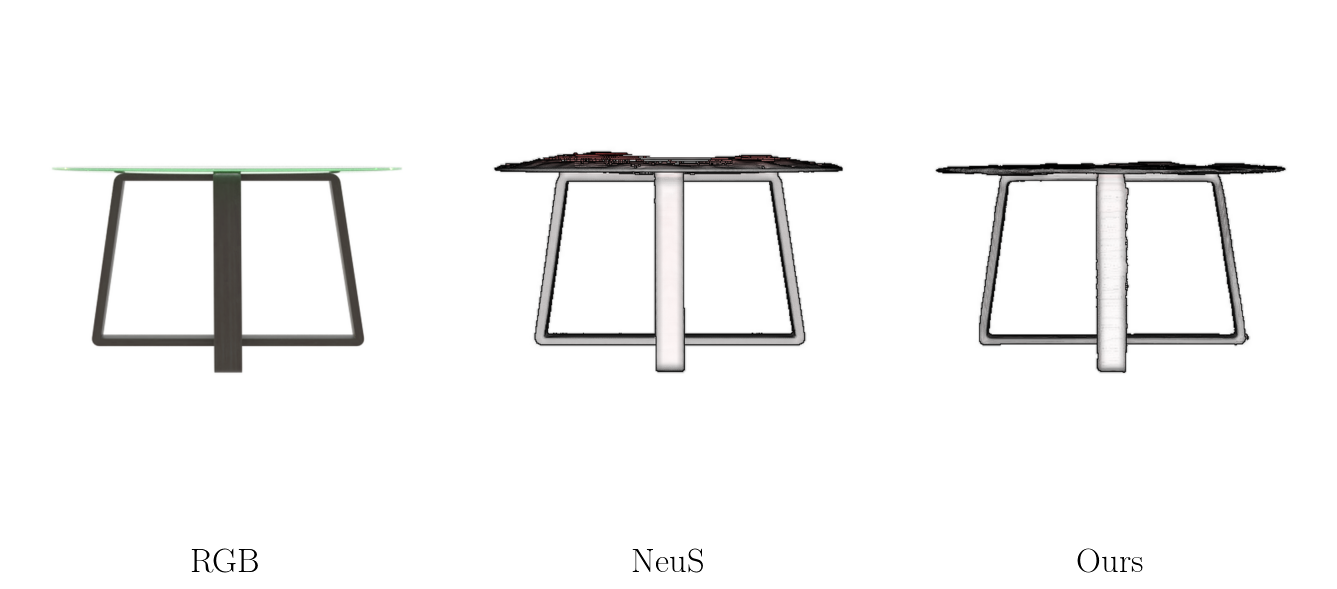

In [8]:
img_idx = 100

scene = 'dinning_table'

methods = {
    'RGB': '/rds/project/rds-qxpdOeYWi78/plenoxels/data/nerf_synthetic/{}/test',
    'NeuS': '/rds/project/rds-qxpdOeYWi78/NeuS/exp/{}/womask_white/fine_mesh/imgs_pt_vid',
    # 'HFS': '/rds/project/rds-qxpdOeYWi78/HFS/exps_1.5/{}/womask_hfs/fine_mesh/imgs_pt_test',
    # r'MipNeRF360 ($\sigma=50$)': '/rds/project/rds-qxpdOeYWi78/multinerf/results/blender/{}/pts/lv_50_pts/imgs_pt_test',
    # r'Plenoxels ($\sigma=50$)': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/nerf/syn/ckpt_eval_cuvol/thresh_50/ckpt/imgs_pt_test',
    'Ours': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/norm_l12/norm_l12_decay_9_low_tv_2/ckpt_eval_surf_masked/ckpt/imgs_pt_vid',
}

subplot_size=(2.5, 4)
fontsize=25
spacing=0.2
img_size=(650,800)
verbose=False

nrow = 1
ncols = 3
subplot_scale = (1,1)


fig,axes = plt.subplots(
    nrows=nrow, ncols=ncols,
#     figsize=(int(ncols * subplot_size[1]),int(nrow * subplot_size[0])),
    figsize=(17, 14),
    gridspec_kw={'wspace':0.02,'hspace':0.15}
    )


# kwargs = {}
kwargs = {'zoom': 1.25}


for i, method in enumerate(methods):
    imgs_path = methods[method]
    image_set = ImageSet(
        imgs_path.format(scene), 
        verbose=verbose, 
        img_name_pattern = 'r_{}.png' if method=='RGB' else '{:05d}.png', 
        img_size=img_size, 
        **kwargs)

    # ax = axes[i // ncols, i % ncols]
    ax = axes[i]
    im = image_set[img_idx]
    ax.imshow(im)
    # make spines (the box) invisible
    plt.setp(ax.spines.values(), visible=False)
    # remove ticks and labels for the left axis
    ax.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)
#     ax.set_ylabel(method, fontsize=fontsize)
    ax.set_xlabel(method, fontsize=fontsize)

In [3]:
img_idx = 10

frames_dir = Path('paper/vids/circle_frames')
frames_dir.mkdir(exist_ok=True, parents=True)

for img_idx in tqdm(range(200)):

    scene = 'ficus'

    methods = {
        'RGB': '/rds/project/rds-qxpdOeYWi78/plenoxels/data/nerf_synthetic/{}/test',
    #     'GT': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/nerf/syn/ckpt_eval_cuvol/depth_spiral_mode_0.1/remeshed/imgs_gt_pt_test',
        'NeuS': '/rds/project/rds-qxpdOeYWi78/NeuS/exp/{}/womask/fine_mesh/imgs_pt_test',
        'HFS': '/rds/project/rds-qxpdOeYWi78/HFS/exps_1.5/{}/womask_hfs/fine_mesh/imgs_pt_test',
        r'MipNeRF360': '/rds/project/rds-qxpdOeYWi78/multinerf/results/blender/{}/pts/lv_30_pts/imgs_pt_vid',
        r'Plenoxels': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/nerf/syn/ckpt_eval_cuvol/thresh_70/ckpt/imgs_pt_vid',
        'Ours': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/good_trunc/solid_less_trunc/ckpt_eval_surf_masked/ckpt/imgs_pt_vid',
    }

    subplot_size=(5, 4)
    fontsize=25
    spacing=0.2
    img_size=(650,800)
    verbose=False

    nrow = 2
    ncols = 3
    subplot_scale = (1,1)


    fig,axes = plt.subplots(
        nrows=nrow, ncols=ncols,
    #     figsize=(int(ncols * subplot_size[1]),int(nrow * subplot_size[0])),
        figsize=(17, 14),
        gridspec_kw={'wspace':0.02,'hspace':0.15}
        )


    # kwargs = {}
    kwargs = {'zoom': 1.25}


    for i, method in enumerate(methods):
        imgs_path = methods[method]
        image_set = ImageSet(
            imgs_path.format(scene), 
            verbose=verbose, 
            img_name_pattern = 'r_{}.png' if method=='RGB' else '{:05d}.png', 
            img_size=img_size, 
            **kwargs)

        ax = axes[i // ncols, i % ncols]
        im = image_set[img_idx]
        ax.imshow(im)
        # make spines (the box) invisible
        plt.setp(ax.spines.values(), visible=False)
        # remove ticks and labels for the left axis
        ax.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)
    #     ax.set_ylabel(method, fontsize=fontsize)
        ax.set_xlabel(method, fontsize=fontsize)




    fig.savefig(str(frames_dir / f'{img_idx:05d}.png'), facecolor='white', bbox_inches='tight')
    plt.close()


In [4]:
# frames_dir = Path('paper/vids/circle_frames')

# imgs = []

# for im_path in sorted(list(frames_dir.glob('*.png'))):
#     im = imageio.imread(str(im_path))
#     imgs.append(im)
    

os.system(f"ffmpeg -framerate 30 -y -pattern_type glob -i '{str(frames_dir)}/*.png' -c:v libx264 -vf 'pad=ceil(iw/2)*2:ceil(ih/2)*2' -pix_fmt yuv420p {str(frames_dir)}/../circle.mp4")


ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.3.0 (GCC)
  configuration: --prefix=/rds/user/tw554/hpc-work/workspace/conda/envs/voxel_sdf --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.10

0

In [2]:
img_idx = 10

frames_dir = Path('paper/vids/circle_frames_trans')
frames_dir.mkdir(exist_ok=True, parents=True)

# for img_idx in tqdm(range(200)):

#     scene = 'dinning_table'

#     methods = {
#         'RGB': '/rds/project/rds-qxpdOeYWi78/plenoxels/data/nerf_synthetic/{}/test',
#         'NeuS': '/rds/project/rds-qxpdOeYWi78/NeuS/exp/{}/womask_white/fine_mesh/imgs_pt_vid',
#         # 'HFS': '/rds/project/rds-qxpdOeYWi78/HFS/exps_1.5/{}/womask_hfs/fine_mesh/imgs_pt_test',
#         # r'MipNeRF360 ($\sigma=50$)': '/rds/project/rds-qxpdOeYWi78/multinerf/results/blender/{}/pts/lv_50_pts/imgs_pt_test',
#         # r'Plenoxels ($\sigma=50$)': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/nerf/syn/ckpt_eval_cuvol/thresh_50/ckpt/imgs_pt_test',
#         'Ours': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/norm_l12/norm_l12_decay_9_low_tv_2/ckpt_eval_surf_masked/ckpt/imgs_pt_vid',
#     }

#     subplot_size=(2.5, 4)
#     fontsize=25
#     spacing=0.2
#     img_size=(650,800)
#     verbose=False

#     nrow = 1
#     ncols = 3
#     subplot_scale = (1,1)


#     fig,axes = plt.subplots(
#         nrows=nrow, ncols=ncols,
#     #     figsize=(int(ncols * subplot_size[1]),int(nrow * subplot_size[0])),
#         figsize=(17, 14),
#         gridspec_kw={'wspace':0.02,'hspace':0.15}
#         )


#     # kwargs = {}
#     kwargs = {'zoom': 1.25}


#     for i, method in enumerate(methods):
#         imgs_path = methods[method]
#         image_set = ImageSet(
#             imgs_path.format(scene), 
#             verbose=verbose, 
#             img_name_pattern = 'r_{}.png' if method=='RGB' else '{:05d}.png', 
#             img_size=img_size, 
#             **kwargs)

#         # ax = axes[i // ncols, i % ncols]
#         ax = axes[i]
#         im = image_set[img_idx]
#         ax.imshow(im)
#         # make spines (the box) invisible
#         plt.setp(ax.spines.values(), visible=False)
#         # remove ticks and labels for the left axis
#         ax.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)
#     #     ax.set_ylabel(method, fontsize=fontsize)
#         ax.set_xlabel(method, fontsize=fontsize)



#     fig.savefig(str(frames_dir / f'{img_idx:05d}.png'), facecolor='white', bbox_inches='tight')
#     plt.close()



frames_dir = Path('paper/vids/circle_frames_trans')
frames_dir.mkdir(exist_ok=True, parents=True)
os.system(f"ffmpeg -framerate 30 -y -pattern_type glob -i '{str(frames_dir)}/*.png' -c:v libx264 -vf 'pad=ceil(iw/2)*2:ceil(ih/2)*2' -pix_fmt yuv420p {str(frames_dir)}/../circle_trans.mp4")



ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.3.0 (GCC)
  configuration: --prefix=/rds/user/tw554/hpc-work/workspace/conda/envs/voxel_sdf --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.10

0

/tmp/ipykernel_28665/3996686195.py:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(str(im_path)).astype('float') / 255
/tmp/ipykernel_28665/3996686195.py:49: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(new_size, Image.LANCZOS)


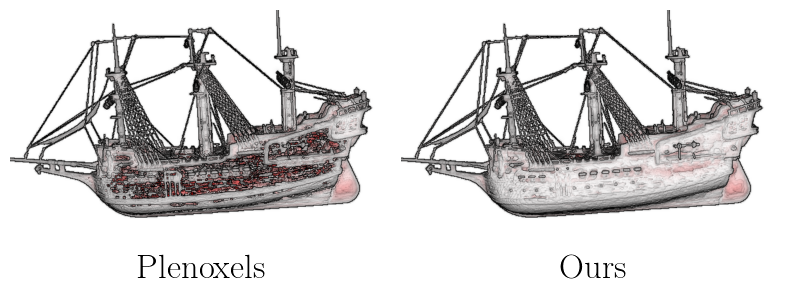

In [5]:
scene = 'ship_re'

img_idx = 0

methods = {
#     'RGB': '/rds/project/rds-qxpdOeYWi78/plenoxels/data/nerf_synthetic/{}/test',
#     'GT': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/nerf/syn/ckpt_eval_cuvol/depth_spiral_mode_0.1/remeshed/imgs_gt_pt_test',
#     'NeuS': '/rds/project/rds-qxpdOeYWi78/NeuS/exp/{}/womask/fine_mesh/imgs_pt_test',
    # r'Plenoxels ($\sigma=50$)': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/nerf/syn/ckpt_eval_cuvol/thresh_50/ckpt/imgs_pt_crop',
    r'Plenoxels': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/nerf/syn/ckpt_eval_cuvol/thresh_50/ckpt/imgs_pt_crop',
#     r'Plenoxels ($\sigma=10$)': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/nerf/syn/ckpt_eval_cuvol/thresh_10/ckpt/imgs_pt_crop',
    'Ours': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/good_trunc/solid_less_trunc/ckpt_eval_surf_single/ckpt/imgs_pt_crop',
}

subplot_size=(5, 4)
fontsize=25
spacing=0.2
img_size=(800,500)
verbose=False

nrow = 1
ncols = 2


fig,axes = plt.subplots(
    nrows=nrow, ncols=ncols,
    figsize=(10, 20),
    gridspec_kw={'wspace':0.02,'hspace':0.15}
    )


kwargs = {'zoom': 1.25}


for i, method in enumerate(methods):
    imgs_path = methods[method]
    image_set = ImageSet(
        imgs_path.format(scene), 
        verbose=verbose, 
        img_name_pattern = 'r_{}.png' if method=='RGB' else '{:05d}.png', 
        img_size=img_size, 
        **kwargs)

    ax = axes[i]
    im = image_set[img_idx]
    ax.imshow(im)
    # make spines (the box) invisible
    plt.setp(ax.spines.values(), visible=False)
    # remove ticks and labels for the left axis
    ax.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)
#     ax.set_ylabel(method, fontsize=fontsize)
    ax.set_xlabel(method, fontsize=fontsize)

In [6]:

frames_dir = Path('paper/vids/crop_frames')
frames_dir.mkdir(exist_ok=True, parents=True)

for img_idx in tqdm(range(60)):

    scene = 'ship_re'

    methods = {
    #     'RGB': '/rds/project/rds-qxpdOeYWi78/plenoxels/data/nerf_synthetic/{}/test',
    #     'GT': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/nerf/syn/ckpt_eval_cuvol/depth_spiral_mode_0.1/remeshed/imgs_gt_pt_test',
    #     'NeuS': '/rds/project/rds-qxpdOeYWi78/NeuS/exp/{}/womask/fine_mesh/imgs_pt_test',
        # r'Plenoxels ($\sigma=50$)': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/nerf/syn/ckpt_eval_cuvol/thresh_50/ckpt/imgs_pt_crop2',
        r'Plenoxels': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/nerf/syn/ckpt_eval_cuvol/thresh_50/ckpt/imgs_pt_crop2',
    #     r'Plenoxels ($\sigma=10$)': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/nerf/syn/ckpt_eval_cuvol/thresh_10/ckpt/imgs_pt_crop',
        'Ours': '/rds/project/rds-qxpdOeYWi78/plenoxels/opt/ckpt/tuning/{}/good_trunc/solid_less_trunc/ckpt_eval_surf_single/ckpt/imgs_pt_crop2',
    }

    subplot_size=(5, 4)
    fontsize=25
    spacing=0.2
    img_size=(800,500)
    verbose=False

    nrow = 1
    ncols = 2


    fig,axes = plt.subplots(
        nrows=nrow, ncols=ncols,
        figsize=(10, 20),
        gridspec_kw={'wspace':0.02,'hspace':0.15}
        )


    kwargs = {'zoom': 1.25}


    for i, method in enumerate(methods):
        imgs_path = methods[method]
        image_set = ImageSet(
            imgs_path.format(scene), 
            verbose=verbose, 
            img_name_pattern = 'r_{}.png' if method=='RGB' else '{:05d}.png', 
            img_size=img_size, 
            **kwargs)

        ax = axes[i]
        im = image_set[img_idx]
        ax.imshow(im)
        # make spines (the box) invisible
        plt.setp(ax.spines.values(), visible=False)
        # remove ticks and labels for the left axis
        ax.tick_params(left=False, bottom=False, labelbottom=False, labelleft=False)
    #     ax.set_ylabel(method, fontsize=fontsize)
        ax.set_xlabel(method, fontsize=fontsize)


    fig.savefig(str(frames_dir / f'{img_idx:05d}.png'), facecolor='white', bbox_inches='tight')
    fig.savefig(str(frames_dir / f'{60*2-1 - img_idx:05d}.png'), facecolor='white', bbox_inches='tight')
    plt.close()


  0%|          | 0/60 [00:00<?, ?it/s]/tmp/ipykernel_28665/3996686195.py:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(str(im_path)).astype('float') / 255
/tmp/ipykernel_28665/3996686195.py:49: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(new_size, Image.LANCZOS)
100%|██████████| 60/60 [01:03<00:00,  1.07s/it]


In [7]:
os.system(f"ffmpeg -y -framerate 30 -y -pattern_type glob -i '{str(frames_dir)}/*.png' -c:v libx264 -vf 'pad=ceil(iw/2)*2:ceil(ih/2)*2' -pix_fmt yuv420p {str(frames_dir)}/../crop.mp4")


ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.3.0 (GCC)
  configuration: --prefix=/rds/user/tw554/hpc-work/workspace/conda/envs/voxel_sdf --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1645955405450/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.10

0